In [127]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler



In [31]:
#Import the churn data set
df = pd.read_csv('churn.csv')

In [34]:
#Explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

In [35]:
#Explore data colums
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,...,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,...,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,...,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,...,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,...,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,...,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [36]:
# This tells us a great deal already as there are no missing values, We have our target in Churn, and there are some
#object variables that need to be converted.  Phone and Area Code can be dropped so let's do that now.

df = df.drop(['Area_Code', 'Phone'], axis = 1)

In [37]:
#Let's make sure that they are gone.
print(df.columns)

Index(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan',
       'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
       'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State'],
      dtype='object')


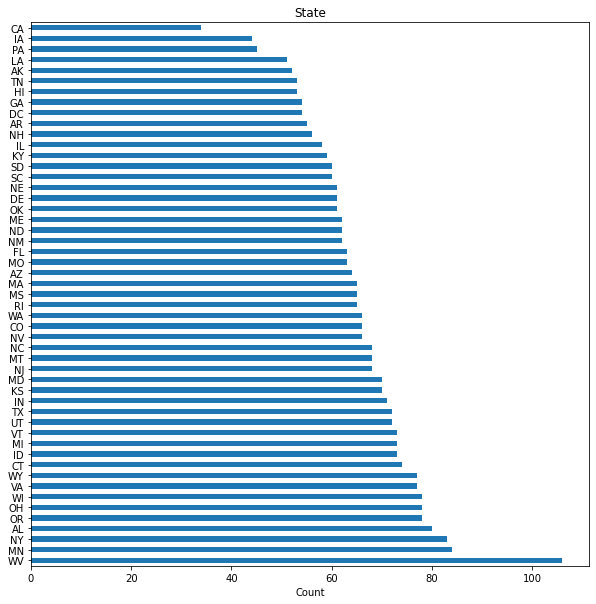

In [39]:
#There are object columns that have to be converted to numeric for modeling unless we want to use a decision tree. 
#Single trees are great for EDA and visualization but have poor predictive power.  One of these values is the State variable.
#Let's take a look at it to see if this may be a relative variable.  One-hot encoding may be needed here.

plt.figure(figsize=(10,10))
df.State.value_counts().plot(kind='barh')
plt.title('State')
plt.xlabel('Count')
plt.show()

In [41]:
#What is going on in West Virginia?  California is the lowest which is strange for it's size. 
# This may need to be explored a little.  Let's see about the percentage of churn vs. no churn. 
# If the percantage is below 5% then we may have an overfitting problem.

print(df.groupby(['Churn']).size() / df.shape[0] * 100)

Churn
no     85.508551
yes    14.491449
dtype: float64


In [42]:
#Only around 14% of the samples have churned which is not ideal but we should be able to model the data.
#Before we convert the categorical variables, let's do some feature engineering because there are some columns that
#may need to be combined or eliminated. The International, daytime, nighttime and evening call minutes can be divided
#by their respective total calls for average call minutes per call.  Let's do that now.

df['Avg_Day_Calls'] = df['Day_Mins'] / df['Day_Calls']
df['Avg_Eve_Calls'] = df['Eve_Mins'] / df['Eve_Calls']
df['Avg_Intl_Calls'] = df['Intl_Mins'] / df['Intl_Calls']
df['Avg_Night_Calls'] = df['Night_Mins'] / df['Night_Calls']

#And let's check the columns/indexes

print(df.columns)

Index(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan',
       'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
       'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Avg_Day_Calls',
       'Avg_Eve_Calls', 'Avg_Intl_Calls', 'Avg_Night_Calls'],
      dtype='object')


In [46]:
#Now, we can create a new dataframe with the previous features dropped by subetting.  That way if there is an error, we can revert
#back to the original df.

df_new = df[['Account_Length', 'Vmail_Message', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan', 'Day_Charge', 'Eve_Charge',
       'Night_Charge', 'Intl_Charge', 'State', 'Avg_Day_Calls',
       'Avg_Eve_Calls', 'Avg_Intl_Calls', 'Avg_Night_Calls' ]]
df_new.head()


,Account_Length,Vmail_Message,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Charge,Eve_Charge,Night_Charge,Intl_Charge,State,Avg_Day_Calls,Avg_Eve_Calls,Avg_Intl_Calls,Avg_Night_Calls
0,128,25,1,no,no,yes,45.07,16.78,11.01,2.70,KS,2.410000,1.993939,3.333333,2.689011
1,107,26,1,no,no,yes,27.47,16.62,11.45,3.70,OH,1.313821,1.898058,4.566667,2.469903
2,137,0,0,no,no,no,41.38,10.30,7.32,3.29,NJ,2.135088,1.101818,2.440000,1.563462
3,84,0,2,no,yes,no,50.90,5.26,8.86,1.78,OH,4.216901,0.703409,0.942857,2.212360
4,75,0,3,no,yes,no,28.34,12.61,8.41,2.73,OK,1.475221,1.215574,3.366667,1.544628


In [52]:
#Now that we have all of the colums we want, we have to decide how to handle the state data before we convert to binary 
#values.  

print(df_new.groupby('State')['Churn'].value_counts().head(20))
print(df_new.groupby('State')['Churn'].value_counts().tail(20))

State  Churn
AK     no       49
       yes       3
AL     no       72
       yes       8
AR     no       44
       yes      11
AZ     no       60
       yes       4
CA     no       25
       yes       9
CO     no       57
       yes       9
CT     no       62
       yes      12
DC     no       49
       yes       5
DE     no       52
       yes       9
FL     no       55
       yes       8
Name: Churn, dtype: int64
State  Churn
SD     no       52
       yes       8
TN     no       48
       yes       5
TX     no       54
       yes      18
UT     no       62
       yes      10
VA     no       72
       yes       5
VT     no       65
       yes       8
WA     no       52
       yes      14
WI     no       71
       yes       7
WV     no       96
       yes      10
WY     no       68
       yes       9
Name: Churn, dtype: int64


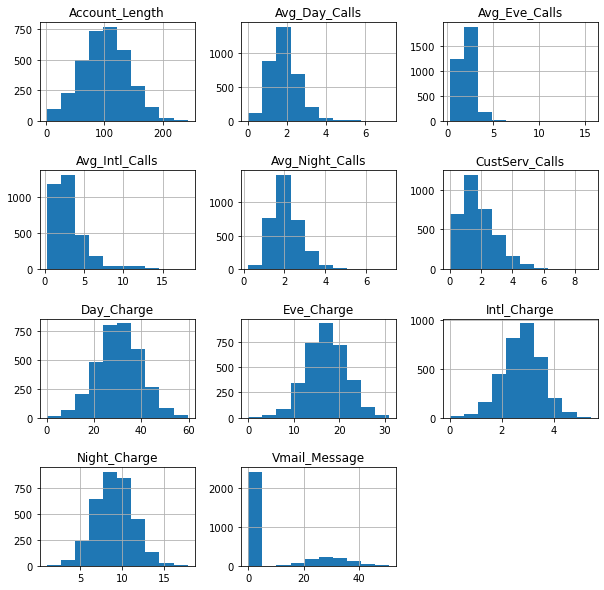

In [56]:
#We can see that different states have higher churn rates so some one-hot encoding would be the order of the day here. 
#But first, let's view some histograms.

df_new.hist(figsize=(10,10))
plt.subplots_adjust(hspace=0.5);

In [57]:
#Some of these values have a normal distribution but some are skewed, namely our new features. Voicemail messages
#appear more categorical but let's check if they are relevant to the target first. We will need to standardize numerical
#variabes.

print(df_new.nunique())

Account_Length      212
Vmail_Message        46
CustServ_Calls       10
Churn                 2
Intl_Plan             2
Vmail_Plan            2
Day_Charge         1667
Eve_Charge         1440
Night_Charge        933
Intl_Charge         162
State                51
Avg_Day_Calls      3259
Avg_Eve_Calls      3253
Avg_Intl_Calls      781
Avg_Night_Calls    3244
dtype: int64


In [58]:
#Essentially, what we see here is that Intl_Plan, Vmail_Plan and State are our categorical variables.  Churn is our target
#and should be removed before modeling.  First, we will standardize the numerical fields using StandardScaler by removing
#the categorical variables.  For now, we will leave in the target so we can run a Decision Tree. First, we will one-hot 
#encode the states.

df_state = pd.get_dummies(df['State'])
state = ['State']
cat = df_new.nunique()[df_new.nunique() < 3].keys().tolist()
numerical = [x for x in df_new.columns if x not in cat + state]

In [59]:
#Here, we will scale the numerical data.

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new[numerical])
df_scaled = pd.DataFrame(df_scaled, columns=numerical)

In [61]:
#We will merge df_state, cat and numerical back together in a final dataframe and make categorical variables binary.

categorical = df_new[['Churn', 'Intl_Plan', 'Vmail_Plan']]
dff = pd.concat([categorical, df_scaled, df_state], axis = 1)
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 65 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   object 
 1   Intl_Plan        3333 non-null   object 
 2   Vmail_Plan       3333 non-null   object 
 3   Account_Length   3333 non-null   float64
 4   Vmail_Message    3333 non-null   float64
 5   CustServ_Calls   3333 non-null   float64
 6   Day_Charge       3333 non-null   float64
 7   Eve_Charge       3333 non-null   float64
 8   Night_Charge     3333 non-null   float64
 9   Intl_Charge      3333 non-null   float64
 10  Avg_Day_Calls    3331 non-null   float64
 11  Avg_Eve_Calls    3332 non-null   float64
 12  Avg_Intl_Calls   3315 non-null   float64
 13  Avg_Night_Calls  3333 non-null   float64
 14  AK               3333 non-null   uint8  
 15  AL               3333 non-null   uint8  
 16  AR               3333 non-null   uint8  
 17  AZ            

In [62]:
#Now we will convert our categorical variables and our target into binary variables and call a Decision Tree for EDA.

dff['Vmail_Plan'] = dff['Vmail_Plan'].replace({'no':0, 'yes':1})
dff['Intl_Plan'] = dff['Intl_Plan'].replace({'no':0, 'yes':1})
dff['Churn'] = dff['Churn'].replace({'no':0, 'yes':1})

In [63]:
#Let's check our data with head() to ensure that we are ready for modeling.
dff.head()

,Churn,Intl_Plan,Vmail_Plan,Account_Length,Vmail_Message,CustServ_Calls,Day_Charge,Eve_Charge,Night_Charge,Intl_Charge,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,1,0.676489,1.234883,-0.427932,1.567036,-0.070427,0.866029,-0.085690,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0.149065,1.307948,-0.427932,-0.334013,-0.107549,1.059390,1.241169,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0.902529,-0.591760,-1.188218,1.168464,-1.573900,-0.755571,0.697156,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,-0.428590,-0.591760,0.332354,2.196759,-2.743268,-0.078806,-1.306401,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,-0.654629,-0.591760,1.092641,-0.240041,-1.037939,-0.276562,-0.045885,...,0,0,0,0,0,0,0,0,0,0


In [94]:
#Now, we will define our target as X and the rest of dff as y and run a decision tree. This will be used for plotting and
#visualization as opposed to assessing model performance. We will try a test size of 1/4 and check the split. 
y = dff['Churn']
X = dff.drop(['Churn'], axis=1)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape[0] / X.shape[0])
print(X_test.shape[0] / X.shape[0])



0.7497749774977498
0.2502250225022502


In [97]:
#Let's see what kind of tree we can get and what features the tree displays as important.
clf = tree.DecisionTreeClassifier(max_depth = 7, criterion = 'gini', splitter = 'best')
modelT = clf.fit(X_train, y_train)
pred_y = modelT.predict(X_test)
print("Training accuracy: ", np.round(clf.score(X_train, y_train), 3))
print("Test accuracy: ", np.round(accuracy_score(y_test, pred_y), 3))


Training accuracy:  0.966
Test accuracy:  0.941


In [100]:
#Wow, that is a ridiculous test accuracy. I almost wonder if I am doing something wrong.  Let's check and print out the tree.

test_precision = round(precision_score(y_test, pred_y), 4)
test_recall = round(recall_score(y_test, pred_y), 4)
print('Test precision: {}, Test recall: {}'.format(test_precision, test_recall))

Test precision: 0.8165, Test recall: 0.7542


In [103]:
#This is pretty good but let's optimize the tree.  
depth_list = list(range(2, 15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:,0] = depth_list
for index in range(len(depth_list)):
    clf = DecisionTreeClassifier(max_depth=depth_list[index])
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    depth_tuning[index,1] = accuracy_score(y_test, pred_y)
    depth_tuning[index,2] = precision_score(y_test, pred_y)
    depth_tuning[index,3] = recall_score(y_test, pred_y)
col_names = ['Max_Depth', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(depth_tuning, columns=col_names))

    Max_Depth  Accuracy  Precision    Recall
0         2.0  0.880096   0.590000  0.500000
1         3.0  0.904077   0.816667  0.415254
2         4.0  0.920863   0.833333  0.550847
3         5.0  0.929257   0.756522  0.737288
4         6.0  0.943645   0.819820  0.771186
5         7.0  0.943645   0.831776  0.754237
6         8.0  0.946043   0.861386  0.737288
7         9.0  0.940048   0.826923  0.728814
8        10.0  0.940048   0.826923  0.728814
9        11.0  0.935252   0.807692  0.711864
10       12.0  0.936451   0.798165  0.737288
11       13.0  0.936451   0.798165  0.737288
12       14.0  0.931655   0.769912  0.737288


[Text(892.0923913043478, 1019.25, 'X[5] <= 1.555\ngini = 0.249\nsamples = 2499\nvalue = [2134, 365]'),
 Text(598.9402173913043, 883.35, 'X[4] <= 1.473\ngini = 0.203\nsamples = 2337\nvalue = [2069, 268]'),
 Text(404.3478260869565, 747.45, 'X[0] <= 0.5\ngini = 0.146\nsamples = 2149\nvalue = [1978, 171]'),
 Text(242.60869565217388, 611.55, 'X[5] <= 0.815\ngini = 0.094\nsamples = 1949\nvalue = [1853, 96]'),
 Text(131.41304347826085, 475.65, 'X[6] <= 2.826\ngini = 0.056\nsamples = 1675\nvalue = [1627, 48]'),
 Text(80.8695652173913, 339.75, 'X[6] <= -0.635\ngini = 0.054\nsamples = 1671\nvalue = [1625, 46]'),
 Text(40.43478260869565, 203.85000000000002, 'X[54] <= 0.5\ngini = 0.017\nsamples = 472\nvalue = [468, 4]'),
 Text(20.217391304347824, 67.95000000000005, 'gini = 0.009\nsamples = 465\nvalue = [463, 2]'),
 Text(60.65217391304347, 67.95000000000005, 'gini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(121.30434782608694, 203.85000000000002, 'X[6] <= -0.626\ngini = 0.068\nsamples = 1199\nval

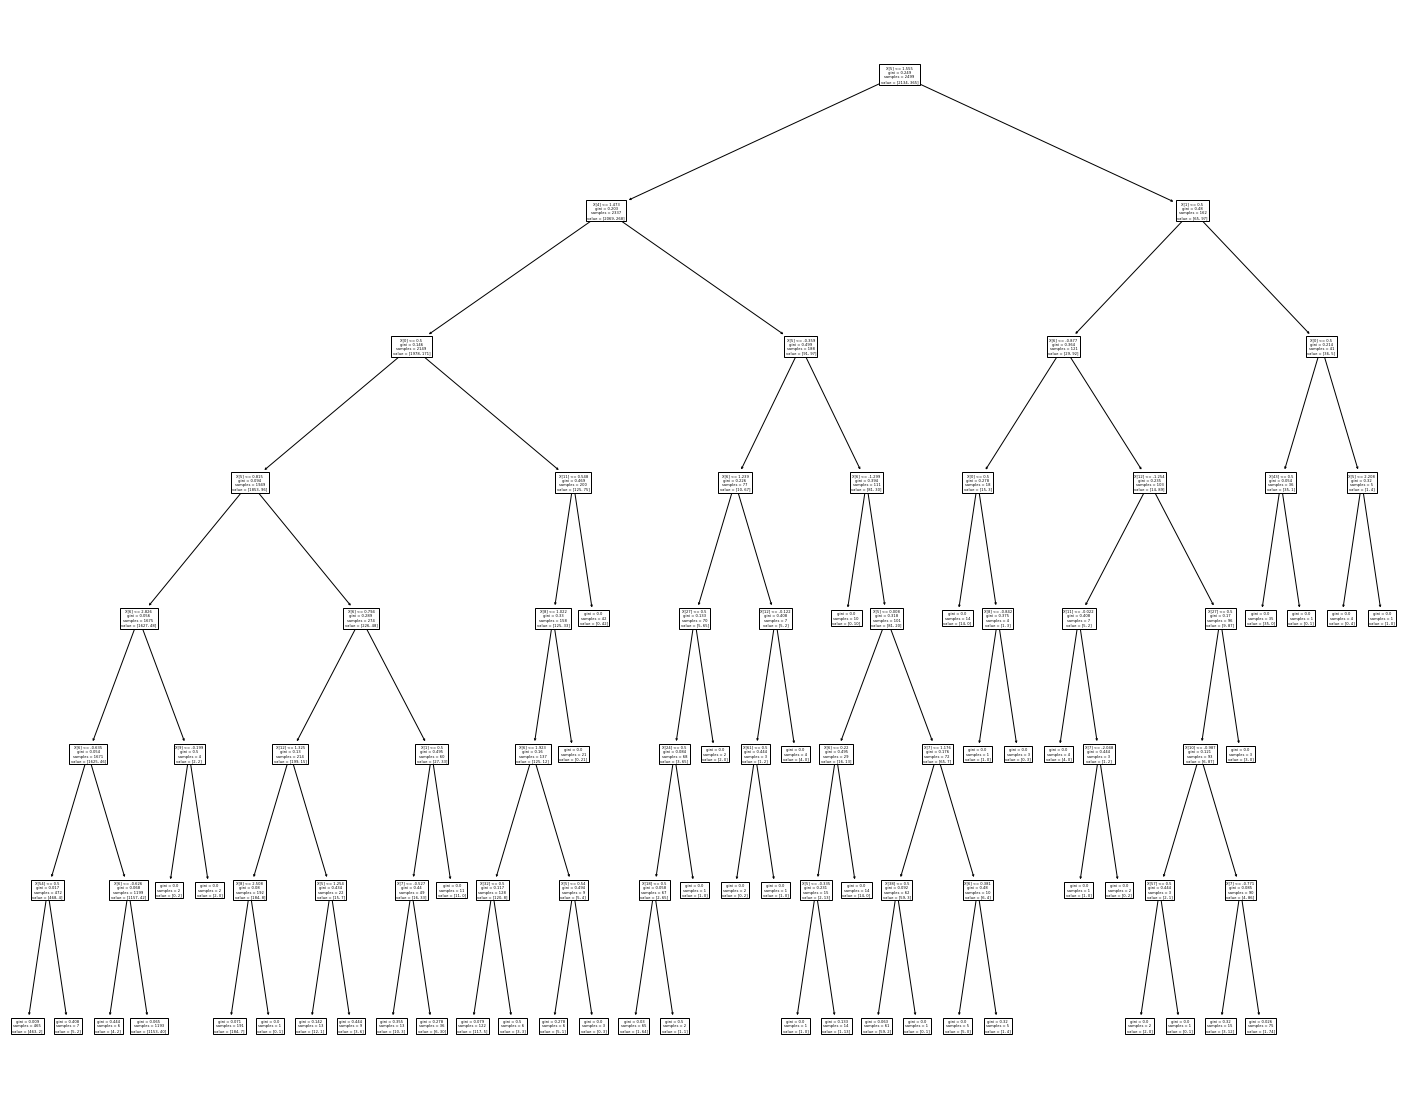

In [119]:
#We can see that somewhere between 6 and 8 is advantageous. We will stick with our results. Next, we will determine which 
#features the decision tree finds to be most influential and plot the tree.

clf = tree.DecisionTreeClassifier(max_depth = 7, criterion = 'gini', splitter = 'best')
modelT = clf.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, filled=True)





In [120]:
#Well, that's not going to help.  On to logisic regression where we can use information to determine best features.

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
test_accuracy = accuracy_score(y_test, pred_y)
print('Test accuracy for logistic regression: ', round(test_accuracy, 4))


Test accuracy for logistic regression:  0.9317


In [123]:
#The accuracy is not quite as good as the decision tree but we cannot rely on just one tree.  Let's see if we can 
#optimize the logistic regression model with lasso regularization that helps with overfitting and maybe some feature selection.

C = [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005]
l1_metrics = np.zeros((len(C), 5))
l1_metrics[:,0] = C
for index in range(0, len(C)):
    logreg = LogisticRegression(penalty = 'l1', C=C[index], solver='liblinear')
    logreg.fit(X_train, y_train)
    pred_Y = logreg.predict(X_test)
    l1_metrics[index, 1] = np.count_nonzero(logreg.coef_)
    l1_metrics[index, 2] = accuracy_score(y_test, pred_Y)
    l1_metrics[index, 3] = precision_score(y_test, pred_Y)
    l1_metrics[index, 4] = recall_score(y_test, pred_Y)
col_names = ['C', 'Non-Zero Coefficients', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(l1_metrics, columns=col_names))


       C  Non-Zero Coefficients  Accuracy  Precision    Recall
0  1.000                   51.0  0.858513   0.500000  0.237288
1  0.500                   40.0  0.862110   0.528302  0.237288
2  0.250                   19.0  0.862110   0.531915  0.211864
3  0.100                   10.0  0.863309   0.555556  0.169492
4  0.050                   10.0  0.860911   0.541667  0.110169
5  0.025                    7.0  0.860911   0.750000  0.025424
6  0.010                    2.0  0.858513   0.000000  0.000000
7  0.005                    0.0  0.858513   0.000000  0.000000


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
#Well, not much can be said with such low recall numbers.  At 7 coefficients, precision is high but recall is really low.
# A value of 10 may be good choice.  There must be lot of false negatives in this model.  

logreg = LogisticRegression(penalty = 'l1', C=8, solver='liblinear')
logreg.fit(X_train, y_train)
pred_y = logreg.predict(X_test)
feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coefficients = pd.concat([feature_names, log_coef], axis = 1)
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients[coefficients['Coefficient']!=0]
print(coefficients.sort_values(by=['Exp_Coefficient']))
                           

       Feature  Coefficient  Exp_Coefficient
1   Vmail_Plan    -2.312057         0.099057
27          IL    -1.697850         0.183077
24          HI    -1.672179         0.187837
58          VA    -1.376488         0.252464
25          IA    -1.102801         0.331940
..         ...          ...              ...
5   Day_Charge     0.775002         2.170596
17          CA     0.895359         2.448215
38          MS     1.011817         2.750593
53          SC     1.117446         3.057037
0    Intl_Plan     2.235910         9.354987

[61 rows x 3 columns]


In [130]:
#Looks like the Voicemail plan may have something to do with churn but what about Illinois and Hawaii?  Are these regions
#susceptible to churn?  Let's get our data into a Random Forest Model.  

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
print(clf.score(X_test, y_test))

0.9376498800959233


In [131]:
#Ok, let's check a support vector machine classifier and compare the two.
clf_svm = SVC()
clf_svm.fit(X_train, y_train)
pred_y = clf.predict(X_test)
print(clf.score(X_test, y_test))

0.9376498800959233


[[712   4]
 [ 48  70]]
0.9459459459459459
0.5932203389830508


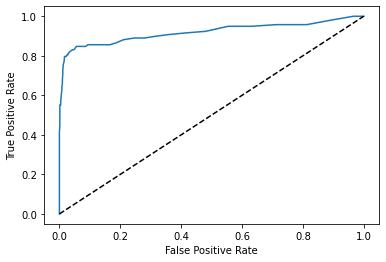

In [132]:
#That is quite interesting and maybe the data has been overfit.  Let's go with the Random Forest and find out. 
#Let's take a look at a confusion matrix which will give us a sense of true and false positives and negatives and the
#ROC curve

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
print(confusion_matrix(y_test, pred_y))
print(precision_score(y_test, pred_y))
print(recall_score(y_test, pred_y))

y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()


In [133]:
#Let's take a look at the area under the ROC curve.

print(roc_auc_score(y_test, y_pred_prob))

0.9191127734116088


In [135]:
#Now we will view the F1 score which is precision and recall in a single metric.

print(f1_score(y_test, pred_y))

0.7291666666666666


In [136]:
#The Random Forest Classifier seems to be a pretty good model. Now, we are going to use a cross-validation method to 
#optimize the model called GridSearchCV.  

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X, y)
print(grid_search.best_params_)


{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10}


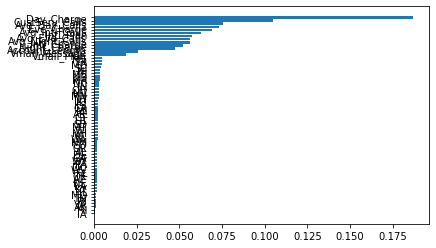

In [140]:
#Now, we will take a look at important features.

importances = clf.feature_importances_
sorted_index = np.argsort(importances)

labels = X.columns[sorted_index]

plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()

In [141]:
#We can clearly see that state features are not as important as other features in a random forest.  Let's drop those.

dfff = pd.concat([categorical, df_scaled], axis = 1)
dfff['Vmail_Plan'] = dfff['Vmail_Plan'].replace({'no':0, 'yes':1})
dfff['Intl_Plan'] = dfff['Intl_Plan'].replace({'no':0, 'yes':1})
dfff['Churn'] = dfff['Churn'].replace({'no':0, 'yes':1})
dfff.head()

,Churn,Intl_Plan,Vmail_Plan,Account_Length,Vmail_Message,CustServ_Calls,Day_Charge,Eve_Charge,Night_Charge,Intl_Charge,Avg_Day_Calls,Avg_Eve_Calls,Avg_Intl_Calls,Avg_Night_Calls
0,0,0,1,0.676489,1.234883,-0.427932,1.567036,-0.070427,0.866029,-0.085690,0.734786,-0.141600,0.097745,0.841837
1,0,0,1,0.149065,1.307948,-0.427932,-0.334013,-0.107549,1.059390,1.241169,-0.763862,-0.265233,0.643354,0.533006
2,0,0,0,0.902529,-0.591760,-1.188218,1.168464,-1.573900,-0.755571,0.697156,0.358938,-1.291940,-0.297454,-0.744616
3,0,1,0,-0.428590,-0.591760,0.332354,2.196759,-2.743268,-0.078806,-1.306401,3.205103,-1.805666,-0.959769,0.170001
4,0,1,0,-0.654629,-0.591760,1.092641,-0.240041,-1.037939,-0.276562,-0.045885,-0.543203,-1.145258,0.112491,-0.771162


In [145]:
#We will run it all again with the final dataframe and see what the results are after we create a new partition.

y = dfff['Churn']
X = dfff.drop(['Churn'], axis=1)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape[0] / X.shape[0])
print(X_test.shape[0] / X.shape[0])


0.7497749774977498
0.2502250225022502


0.9376498800959233
[[696   6]
 [ 46  86]]
0.9347826086956522
0.6515151515151515


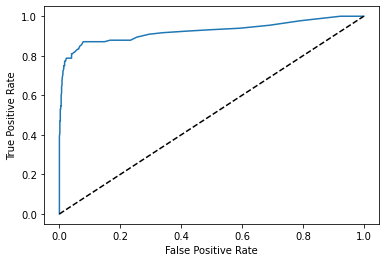

0.924549987049987
0.7678571428571428


In [146]:
#Let's take a look at a confusion matrix which will give us a sense of true and false positives and negatives and the
#ROC curve forthe final dataframe with states removed.

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
print(clf.score(X_test, y_test))
print(confusion_matrix(y_test, pred_y))
print(precision_score(y_test, pred_y))
print(recall_score(y_test, pred_y))

y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

print(roc_auc_score(y_test, y_pred_prob))
print(f1_score(y_test, pred_y))


In [147]:
# The numbers are relatively similar so let's look at the best parameters and best features. Now, we are going to 
#use GridSearchCV on the final dataframe.  

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10}


0.9496402877697842
[[696   6]
 [ 36  96]]
0.9411764705882353
0.7272727272727273


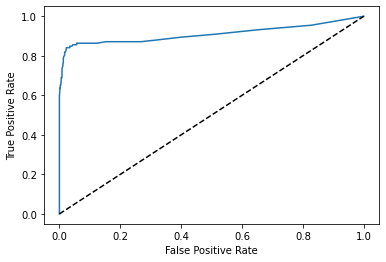

0.9095765345765345
0.8205128205128205


In [148]:
#Interesting,the bootstrap changed to the default! Let's run the Random Forest Classifier with these hyperparams!

clf = RandomForestClassifier(criterion = 'entropy', max_features = 10)
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
print(clf.score(X_test, y_test))
print(confusion_matrix(y_test, pred_y))
print(precision_score(y_test, pred_y))
print(recall_score(y_test, pred_y))

y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

print(roc_auc_score(y_test, y_pred_prob))
print(f1_score(y_test, pred_y))



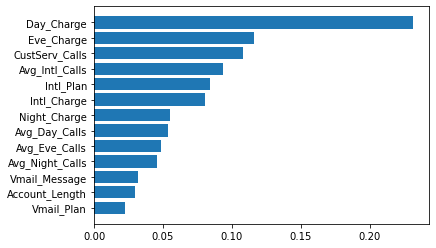

In [149]:
#Finally, we will observe the most predictive features of the Random Forest Model.

importances = clf.feature_importances_
sorted_index = np.argsort(importances)

labels = X.columns[sorted_index]

plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()